# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *

# Define the FarmEnv class
class FarmEnv:
    def __init__(self, farm: Farm, reward_function=None):
        self.game = farm  # Accept a Farm instance directly
        self.done = False
        self.reward_function = reward_function or self.default_reward

    def reset(self):
        self.game = configure_game()  # Reset the game
        self.done = False
        return self.get_state()

    def step(self, action):
        current_player = self.game.whose_turn()["name"]
        self.game = self.game.take_action(action, inplace=True)  # Apply action
        reward = self.reward_function(self.game, current_player)  # Calculate reward
        self.done = self.game.is_done()  # Check if game is done
        new_state = self.get_state()  # Get the updated state
        return new_state, reward, self.done, {}  # Return updated state

    def get_state(self):
        return self.game

    def render(self):
        self.game.print_farm()

    def default_reward(self, game, player):
        return game.playersDict[player]["score"]

# Training

In [2]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.99, epsilon=0.2, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        """
        Update the agent with the current state.
        """
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        """
        return tuple(state)  # Assuming the state can be represented as a tuple

    def get_q_value(self, state, action):
        """
        Retrieve the Q-value for a given state-action pair.
        """
        state_rep = self.get_state_representation(state)
        return self.q_table.get((state_rep, action), 0.0)

    def choose_action(self):
        """
        Choose an action based on epsilon-greedy policy.
        """
        actions = self.current_state.legal_actions()  # Access legal actions from the full state
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            return random.choice(actions)

        # Exploit: Choose the best action based on Q-values
        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        return random.choice(best_actions)

    def update_q_value(self, action, reward, next_state):
        """
        Update the Q-value for the given state-action pair using the Q-learning formula.
        """
        # Get hashable representations of the states
        state_rep = self.get_state_representation(self.current_state)
        next_state_rep = self.get_state_representation(next_state)

        # Get the maximum Q-value for the next state
        next_actions = next_state.legal_actions()
        max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)

        # Compute the TD target and error
        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        # Update the Q-value
        self.q_table[(state_rep, action)] = self.get_q_value(self.current_state, action) + self.learning_rate * td_error

    def decay_epsilon(self, decay_rate=0.99):
        """
        Decay the exploration rate (epsilon) over time.
        """
        self.epsilon = max(0.01, self.epsilon * decay_rate)


In [3]:
def train_q_learning_agent(env, num_episodes=1000, max_steps_per_episode=100):
    # Initialize two Q-learning agents
    agent1 = QLearningAgent(learning_rate=0.1, discount_factor=0.99, epsilon=0.2)
    agent2 = QLearningAgent(learning_rate=0.1, discount_factor=0.99, epsilon=0.2)

    final_rewards_red = []  # To store the final rewards of the 'red' player
    final_rewards_purple = []  # To store the final rewards of the 'purple' player
    helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
    helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

    for episode in range(num_episodes):
        print(f"\nStarting Episode {episode + 1}/{num_episodes}")

        state = env.reset()  # Reset the environment for a new episode
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0  # Counter for red's helpful moves
        purple_helpful_count = 0  # Counter for purple's helpful moves

        for step in range(max_steps_per_episode):
            print(f"\nTurn {step + 1}")

            # Agent 1's turn (Red)
            action1 = agent1.choose_action()
            print(f"Red Player Action: {action1}")

            # Check if the action is helpful
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1
                print("Red Player made a helpful move.")

            state = state.take_action(action1, inplace=True)

            if state.is_done():  # Check if the game is over
                print("Game Over!")
                break

            # Agent 2's turn (Purple)
            action2 = agent2.choose_action()
            print(f"Purple Player Action: {action2}")

            # Check if the action is helpful
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1
                print("Purple Player made a helpful move.")

            state = state.take_action(action2, inplace=True)

            if state.is_done():  # Check if the game is over
                print("Game Over!")
                break

        # Calculate final rewards at the end of the episode
        red_rwd, red_done = state.reward("red")
        purple_rwd, purple_done = state.reward("purple")

        # Record final rewards
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        # Record the number of helpful moves
        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        print(f"Episode {episode + 1} Completed: Total Red Reward = {red_rwd}, Total Purple Reward = {purple_rwd}")
        print(f"Helpful Moves: Red = {red_helpful_count}, Purple = {purple_helpful_count}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple

In [4]:
farm_instance = configure_game()  # Ensure this function initializes the Farm object correctly
env = FarmEnv(farm_instance)

agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(env, num_episodes=1000)


Starting Episode 1/1000

Turn 1
Red Player Action: Turnip00(12,13)
Red Player made a helpful move.
Purple Player Action: Turnip02(13,14)

Turn 2
Red Player Action: Tomato01(7,8)
Purple Player Action: Strawberry00(7,7)
Purple Player made a helpful move.

Turn 3
Red Player Action: Eggplant00(12,14)
Red Player made a helpful move.
Purple Player Action: box(16,5)

Turn 4
Red Player Action: box(16,5)
Purple Player Action: Turnip01(13,13)

Turn 5
Red Player Action: Tomato00(8,7)
Purple Player Action: Strawberry01(8,8)
Purple Player made a helpful move.

Turn 6
Red Player Action: box(16,5)
Purple Player Action: purplepillow(8,8)

Turn 7
Red Player Action: rednone(15,7)
Purple Player Action: box(16,5)
Game Over!
Episode 1 Completed: Total Red Reward = 116, Total Purple Reward = 108
Helpful Moves: Red = 2, Purple = 2

Starting Episode 2/1000

Turn 1
Red Player Action: Tomato00(8,7)
Purple Player Action: Turnip02(13,14)

Turn 2
Red Player Action: Eggplant00(12,14)
Red Player made a helpful move

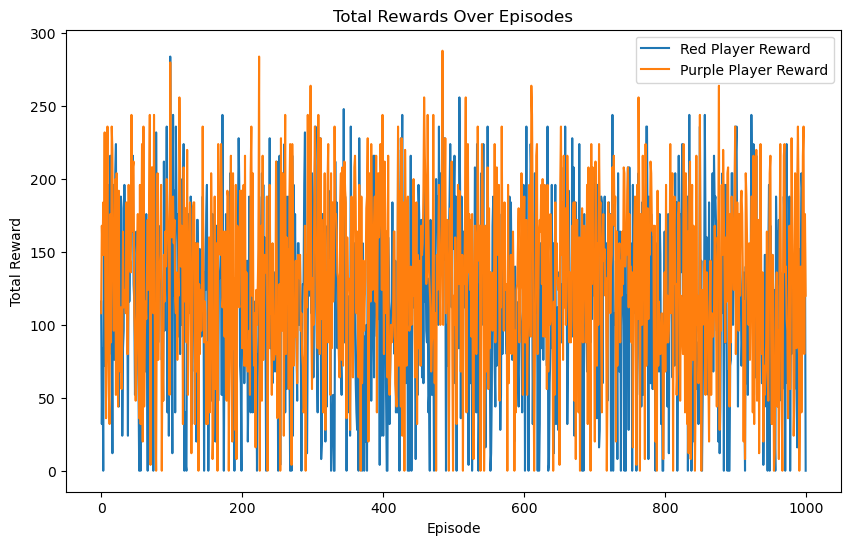

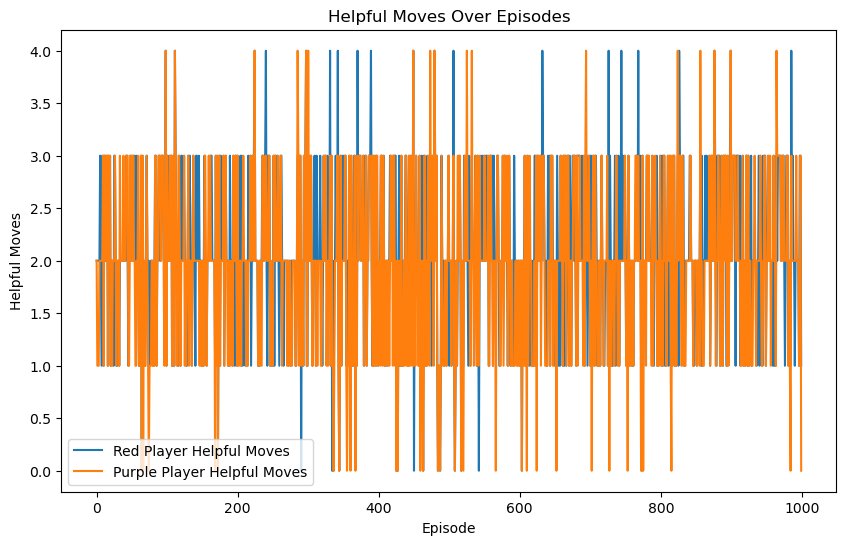

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


In [6]:
# class QLearningAgent:
#     def __init__(self, actions, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
#         self.q_table = {}  # Dictionary to store Q-values
#         self.actions = actions
#         self.learning_rate = learning_rate
#         self.discount_factor = discount_factor
#         self.epsilon = epsilon

#     def get_q_value(self, state, action):
#         return self.q_table.get((state, action), 0.0)

#     def choose_action(self, state):
#         if random.random() < self.epsilon:  # Explore
#             return random.choice(self.actions)
#         else:  # Exploit
#             q_values = [self.get_q_value(state, a) for a in self.actions]
#             return self.actions[np.argmax(q_values)]

#     def update_q_value(self, state, action, reward, next_state):
#         max_q_next = max([self.get_q_value(next_state, a) for a in self.actions], default=0)
#         td_target = reward + self.discount_factor * max_q_next
#         td_error = td_target - self.get_q_value(state, action)
#         new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
#         self.q_table[(state, action)] = new_q_value
